In [1]:
import pandas as pd

import numpy as np

import itertools

from datetime import datetime

import time

import pytz
import sys
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, max_error, r2_score

import seaborn as sns

import MetaTrader5 as mt5

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# LOAD DATA

In [2]:
sSymbol = "USDJPY"
gc_o_TIME_ZONE = pytz.timezone("Etc/UTC")
gc_dt_FROM = datetime(2021, 8, 1, tzinfo=gc_o_TIME_ZONE)
gc_dt_TO = datetime(2021, 9, 15, tzinfo=gc_o_TIME_ZONE)

In [3]:
aDatesToFetch = list(pd.date_range(start=gc_dt_FROM, end=gc_dt_TO)) #created since MT5 library fails due to time out.
aDatesSampled = aDatesToFetch[::200]
aDatesSampled.append(aDatesToFetch[-1])
aDatesSampled = list(set(aDatesSampled))
aDatesSampled.sort()

dfOhlc = pd.DataFrame()
for i in range(0, len(aDatesSampled) - 1):
    dtFrom = aDatesSampled[i]
    dtTo = aDatesSampled[i+1]

    if not mt5.initialize():
        print("initialize() failed, error code =", mt5.last_error())
        sys.exit()

    aSymbolInfo = mt5.symbol_info(sSymbol)
    if not aSymbolInfo:
        print("symbol_info() failed, error code =", mt5.last_error())
        sys.exit()

    dfOhlcSample = mt5.copy_rates_range(
        sSymbol,
        mt5.TIMEFRAME_M30,
        dtFrom, 
        dtTo
    )
    
    if len(dfOhlcSample) == 0:
        print("copy_rates_range() failed, error code =", mt5.last_error())
        sys.exit()

    mt5.shutdown()

    dfOhlcSample = pd.DataFrame(dfOhlcSample)

    dfOhlcSample['timestamp'] = pd.to_datetime(dfOhlcSample['time'], unit= "s")
    dfOhlcSample.set_index('timestamp', inplace=True)
    
    dfOhlc = dfOhlc.append(dfOhlcSample)

In [4]:
dfOhlc["weekday"] = dfOhlc.index.weekday
dfOhlc["hour"] = dfOhlc.index.hour
dfOhlc["minute"] = dfOhlc.index.minute

In [5]:
dfOhlc["return"] = (dfOhlc["close"] - dfOhlc["open"])/dfOhlc["open"]

In [6]:
dfOhlc.drop(["time"], axis = 1 , inplace = True)

# DESCRIBE DATA

In [7]:
dfOhlc

,open,high,low,close,tick_volume,spread,real_volume,weekday,hour,minute,return
timestamp,,,,,,,,,,,
2021-08-02 00:00:00,109.605,109.720,109.595,109.663,368,16,55200000,0,0,0,0.000529
2021-08-02 00:30:00,109.666,109.697,109.586,109.677,890,13,133500000,0,0,30,0.000100
2021-08-02 01:00:00,109.677,109.755,109.670,109.704,4521,13,678150000,0,1,0,0.000246
2021-08-02 01:30:00,109.704,109.725,109.691,109.708,3111,13,466650000,0,1,30,0.000036
2021-08-02 02:00:00,109.708,109.766,109.708,109.743,5456,13,818400000,0,2,0,0.000319
...,...,...,...,...,...,...,...,...,...,...,...
2021-09-14 22:00:00,109.621,109.634,109.608,109.617,12593,12,1888950000,1,22,0,-0.000036
2021-09-14 22:30:00,109.617,109.649,109.613,109.649,11406,12,1710900000,1,22,30,0.000292
2021-09-14 23:00:00,109.648,109.668,109.642,109.655,6733,12,1009950000,1,23,0,0.000064


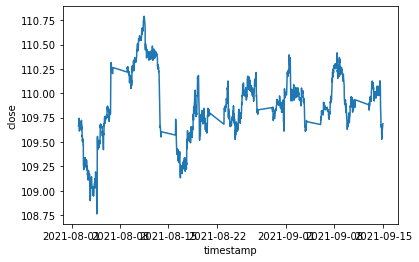

In [8]:
sns.lineplot(data  = dfOhlc["close"])

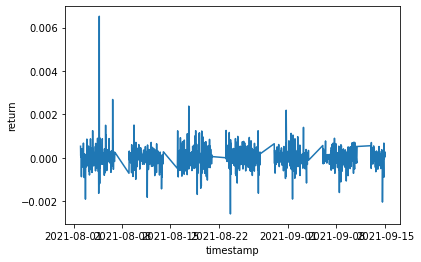

In [9]:
sns.lineplot(data  = dfOhlc["return"])

# PREPROCESSING

In [10]:
sModelName = os.path.join(sSymbol , "__deep learning model__")

## Split Data

In [11]:
fTrainingRatio = 0.6
fValidationRatio = 0.2
fTestRatio = 0.2

ixTrain, ixTest = train_test_split(
    dfOhlc.index,
    test_size=1-fTrainingRatio,
    shuffle=False)

ixValidation, ixTest= train_test_split(
    ixTest,
    test_size=fTestRatio/(fTestRatio + fValidationRatio),
    shuffle=False)

## Scale Data

In [12]:
dfScaledOhlc = pd.DataFrame(index = dfOhlc.index, columns  = dfOhlc.columns)


for sColumn in dfOhlc.columns:
    oScaler = StandardScaler()
    
    dfTrain = pd.DataFrame(dfOhlc.loc[ixTrain, sColumn])
    dfValidation = pd.DataFrame(dfOhlc.loc[ixValidation, sColumn])
    dfTest = pd.DataFrame(dfOhlc.loc[ixTest, sColumn])
    
    oScaler.fit(dfTrain)
    
    dfScaledOhlc.loc[ixTrain, sColumn] = np.reshape(oScaler.transform(dfTrain), (-1))
    dfScaledOhlc.loc[ixValidation, sColumn] = np.reshape(oScaler.transform(dfValidation), (-1))
    dfScaledOhlc.loc[ixTest, sColumn] = np.reshape(oScaler.transform(dfTest), (-1))

    sScalerFilePath = os.path.join(sModelName , "__scalers__")
    sScalerFilePath = os.path.join(sScalerFilePath , sColumn + ".sav")
    os.makedirs(os.path.dirname(sScalerFilePath), exist_ok=True)
    pickle.dump(oScaler, open(sScalerFilePath, 'wb'))

## Feature Engineering

In [13]:
aInputFeatures = ['open', 'high', 'low', 'close', 'tick_volume', 'spread', 'real_volume','weekday', 'hour', 'minute']
iBackwardTimeWindow = 8
iNrInputFeatures = len(aInputFeatures)
aBackwardTimeSteps = range(-iBackwardTimeWindow, 0)

tplInputColumns = list(itertools.product(aBackwardTimeSteps, aInputFeatures))
miInputColums = pd.MultiIndex.from_tuples(tplInputColumns, names= ["time_step", "feature"])

dfInput = pd.DataFrame( columns = miInputColums)

for i in aBackwardTimeSteps:
    for sInputFeature in aInputFeatures:
        dfInput.loc[:, (i, sInputFeature)] = dfScaledOhlc[sInputFeature].shift(-i)

In [14]:
aOutputFeatures = ['close']
iForwardTimeWindow  =  8
iNrOutputFeatures = len(aOutputFeatures)
aForwardTimeSteps = range(0, iForwardTimeWindow)

tplOutputColumns = list(itertools.product(aForwardTimeSteps, aOutputFeatures))
ixOutputColums = pd.MultiIndex.from_tuples(tplOutputColumns, names= ["time_step", "feature"])

dfOutput = pd.DataFrame(columns = ixOutputColums)

for i in aForwardTimeSteps:
    for sOutputFeature in aOutputFeatures:
        dfOutput.loc[:, (i, sOutputFeature)] = dfScaledOhlc[sOutputFeature].shift(-i)
        
        

In [15]:
dfMerged = dfInput.join(dfOutput, how= "inner")
dfMerged.dropna(inplace=True)
dfInput = dfMerged[dfInput.columns]
dfOutput = dfMerged[dfOutput.columns]
ixTrain = ixTrain.join(dfMerged.index, how = "inner")
ixValidation = ixValidation.join(dfMerged.index, how = "inner")
ixTest = ixTest.join(dfMerged.index, how = "inner")

In [16]:
dfInputTrain = dfInput.loc[ixTrain]
aInputTrain = np.reshape(dfInputTrain.values, (dfInputTrain.shape[0], iBackwardTimeWindow, iNrInputFeatures))

dfInputValidation = dfInput.loc[ixValidation]
aInputValidation = np.reshape(dfInputValidation.values, (dfInputValidation.shape[0], iBackwardTimeWindow, iNrInputFeatures))

dfInputTest = dfInput.loc[ixTest]
aInputTest = np.reshape(dfInputTest.values, (dfInputTest.shape[0], iBackwardTimeWindow, iNrInputFeatures))

dfOutputTrain = dfOutput.loc[ixTrain]
aOutputTrain = np.reshape(dfOutputTrain.values, (dfOutputTrain.shape[0], iForwardTimeWindow, iNrOutputFeatures))

dfOutputValidation = dfOutput.loc[ixValidation]
aOutputValidation = np.reshape(dfOutputValidation.values, (dfOutputValidation.shape[0], iForwardTimeWindow, iNrOutputFeatures))

dfOutputTest = dfOutput.loc[ixTest]
aOutputTest = np.reshape(dfOutputTest.values, (dfOutputTest.shape[0], iForwardTimeWindow, iNrOutputFeatures))

In [17]:
aInputTrain = np.asarray(aInputTrain, np.float32)
aInputValidation = np.asarray(aInputValidation, np.float32)
aInputTest = np.asarray(aInputTest, np.float32)
aOutputTrain = np.asarray(aOutputTrain, np.float32)
aOutputValidation = np.asarray(aOutputValidation, np.float32)
aOutputTest = np.asarray(aOutputTest, np.float32)

### Pixel Conversion

In [18]:
iNrOfBins = 28
ixZScoreIntervals = pd.interval_range(-3, 3 , iNrOfBins)

def aConvertToPixels(aNormalizedData):
    #(sample size, feature size, Nr of Bins, time step)
    aConvertedData = np.zeros((aNormalizedData.shape[0] ,   aNormalizedData.shape[2] , iNrOfBins  , aNormalizedData.shape[1]))

    for iI,  aI in enumerate(aNormalizedData): #samples
        for iJ, aJ in enumerate(aI): #time steps
            for iK, fK in enumerate(aJ): #features
                if fK > 0 and fK >= ixZScoreIntervals[-1].right:
                    aConvertedData[iI][iJ][-1] == 1   
                elif fK < 0 and fK <= ixZScoreIntervals[0].left:
                    aConvertedData[iI][iJ][0] == 1   
                else:
                    iFoundIndex = ixZScoreIntervals.get_loc(fK)
                    aConvertedData[iI][iK][iFoundIndex][iJ] = 1
    
    return aConvertedData


def aConvertFromPixels(aPixelData):
    aConvertedData = np.zeros((aPixelData.shape[0] ,  aPixelData.shape[3], aPixelData.shape[1]))

    for iI,  aI in enumerate(aPixelData): #samples
            for iJ, aJ in enumerate(aI): #features
                aJ = np.transpose(aJ)
                for iK, aK in enumerate(aJ): #time steps
                    iMaxIndex = np.argmax(aK)
                    fCenterOfBin = ixZScoreIntervals[iMaxIndex].mid
                    aConvertedData[iI][iK][iJ] = fCenterOfBin

    return aConvertedData
    

aPixelOutputTrain = aConvertToPixels(aOutputTrain)
aPixelOutputValidation = aConvertToPixels(aOutputValidation)
aPixelOutputTest  = aConvertToPixels(aOutputTest)
aPixelInputTrain = aConvertToPixels(aInputTrain)
aPixelInputValidation = aConvertToPixels(aInputValidation)
aPixelInputTest = aConvertToPixels(aInputTest)

## Train

### Set Hyperparameters

In [19]:
iBatchSize = 64
iEpochSize = 10000
iNrOfHiddenNeurons = 32

oEarlyStop = EarlyStopping(
    monitor = 'val_loss', 
    mode = 'min', 
    verbose = 0 , 
    patience = 20, 
    restore_best_weights = True)

### Build Model

#### Deep CNN

In [20]:
# aInputDeepCnn = keras.Input(
#     shape=(iBackwardTimeWindow, iNrInputFeatures))

# aW = keras.layers.LSTM(64, return_sequences = True)(aInputDeepCnn)
# aW = keras.layers.Flatten()(aW)
# aW = keras.layers.Dense(iNrOfBins*iForwardTimeWindow*iNrOutputFeatures)(aW)
# aW = keras.layers.Reshape((iNrOutputFeatures * iNrOfBins, iForwardTimeWindow, 1))(aW)
# aW = keras.layers.Conv2D(64, (4,4), (1,1), padding = "same" )(aW)
# aW = keras.layers.MaxPool2D(pool_size = (4, 4))(aW)
# aW = keras.layers.Flatten()(aW)
# aW = keras.layers.Dense(iNrOfBins*iForwardTimeWindow*iNrOutputFeatures)(aW)
# aW = keras.layers.Reshape((iNrOutputFeatures, iNrOfBins, iForwardTimeWindow))(aW)

# aOutputDeepCnn = aW
# oModelDeepCnn = keras.Model(
#     inputs=aInputDeepCnn,
#     outputs=aOutputDeepCnn
# )

# oOptimizerDeepCnn = tf.keras.optimizers.Adam(learning_rate=1e-05)
# oModelDeepCnn.compile(optimizer=oOptimizerDeepCnn,
#                          loss = "mse"
#                         )

# tf.keras.utils.plot_model(oModelDeepCnn,  show_shapes=True)

#### Deep Convolutional Generative Adversarial Network Model

##### Generator Model

In [21]:
# aInputGenerator = keras.Input(
#     shape=(iBackwardTimeWindow, iNrInputFeatures))

# aW = keras.layers.Flatten()(aInputGenerator)
# aW = keras.layers.Dense(iNrOutputFeatures*iNrOfBins*iForwardTimeWindow, use_bias=False)(aW)
# aW = keras.layers.BatchNormalization()(aW)
# aW = keras.layers.LeakyReLU()(aW)

# aW = keras.layers.Reshape((iNrOutputFeatures*iNrOfBins, iForwardTimeWindow, 1))(aW)

# aW = keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(aW)
# aW = keras.layers.BatchNormalization()(aW)
# aW = keras.layers.LeakyReLU()(aW)

# aW = keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(aW)
# aW = keras.layers.BatchNormalization()(aW)
# aW = keras.layers.LeakyReLU()(aW)

# aW = keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(aW)

# aW = keras.layers.Flatten()(aW)
# aW = keras.layers.Dense(iNrOutputFeatures*iNrOfBins*iForwardTimeWindow, use_bias=False)(aW)
# aW = keras.layers.Reshape((iNrOutputFeatures, iNrOfBins, iForwardTimeWindow))(aW)

# aOutputGenerator = aW
# oModelGenerator = keras.Model(inputs = aInputGenerator, 
#                               outputs = aOutputGenerator)

# def fCalculateGeneratorLoss(aFakeOutput):
#     oCrossEntropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
#     fTotalLoss = oCrossEntropy(tf.ones_like(aFakeOutput), aFakeOutput)
#     return fTotalLoss

# oOptimizerGenerator = tf.keras.optimizers.Adam(learning_rate=1e-05)
# oModelGenerator.compile(optimizer=oOptimizerGenerator,
#                          loss = fCalculateGeneratorLoss
#                         )

# tf.keras.utils.plot_model(oModelGenerator,  show_shapes=True)

##### Discriminator Model

In [22]:
# aInputDiscrimantor= keras.Input(
#     shape=(iNrOutputFeatures, iNrOfBins, iForwardTimeWindow),
#     name = "aInputDiscrimantor")


# aW = keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(aInputDiscrimantor)
# aW = keras.layers.LeakyReLU()(aW)
# aW = keras.layers.Dropout(0.3)(aW)

# aW = keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(aW)
# aW = keras.layers.LeakyReLU()(aW)
# aW = keras.layers.Dropout(0.3)(aW)

# aW = keras.layers.Flatten()(aW)
# aW = keras.layers.Dense(1)(aW)

# def fCalculateDiscrimantorLoss(aRealOutput, aFakeOutput):
#     oCrossEntropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
#     fRealLoss = oCrossEntropy(tf.ones_like(aRealOutput), aRealOutput)
#     fFakeLoss = oCrossEntropy(tf.zeros_like(aFakeOutput), aFakeOutput)
#     fTotalLoss = fRealLoss + fFakeLoss
#     return fTotalLoss

# aOutputDiscriminator = aW
# oModelDiscriminator = keras.Model(
#     inputs=aInputDiscrimantor,
#     outputs=aOutputDiscriminator
# )

# oOptimizerDiscriminator = tf.keras.optimizers.Adam(learning_rate=1e-05)
# oModelDiscriminator.compile(optimizer=oOptimizerDiscriminator,
#                          loss = fCalculateDiscrimantorLoss
#                            )

# tf.keras.utils.plot_model(oModelDiscriminator,  show_shapes=True)

##### GAN Model

In [23]:
# @tf.function
# def trainStep(aOutputActual):
#     aNoiseInput = tf.random.normal([iBatchSize, iBackwardTimeWindow, iNrInputFeatures])

#     with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
#         aOutputGenerated = oModelGenerator(aNoiseInput, training=True)
#         aFake = oModelDiscriminator(aOutputGenerated, training=True)
        
#         aReal = oModelDiscriminator(aOutputActual, training=True)
        
#         fLossGenerator = fCalculateGeneratorLoss(aFake)
#         fLossDiscriminator = fCalculateDiscrimantorLoss(aReal, aFake)

#     aGradientsGenerator = gen_tape.gradient(fLossGenerator, oModelGenerator.trainable_variables)
#     aGradientsDiscriminator = disc_tape.gradient(fLossDiscriminator, oModelDiscriminator.trainable_variables)

#     oOptimizerGenerator.apply_gradients(zip(aGradientsGenerator, oModelGenerator.trainable_variables))
#     oOptimizerDiscriminator.apply_gradients(zip(aGradientsDiscriminator, oModelDiscriminator.trainable_variables))
    
    

# for iEpoch in range(iEpochSize):
#     dtStart = time.time()

#     dsOutputTrain = tf.data.Dataset.from_tensor_slices(aPixelOutputTrain).batch(iBatchSize)
#     for aOutputTrain in dsOutputTrain:
#         trainStep(aOutputTrain)

#     print ('Time for epoch {} is {} sec'.format(iEpoch + 1, time.time()-dtStart))

#### Convolutional Encoder-Decoder Model

In [24]:
# aInputs = keras.Input(
#     shape=(iBackwardTimeWindow, iNrInputFeatures))

# aEncoderHiddens, aFinalH, aFinalC = keras.layers.LSTM(iNrOfHiddenNeurons,
#                                          return_state = True, 
#                                          return_sequences = True
#                                         )(aInputs)
# aFinalH = keras.layers.BatchNormalization()(aFinalH)
# aFinalC = keras.layers.BatchNormalization()(aFinalC)

# aFeatureMap = keras.layers.Conv1D(64, 2)(aEncoderHiddens)
# aFeatureMap = keras.layers.MaxPooling1D(2)(aFeatureMap)
# aFlatted = keras.layers.Flatten()(aFeatureMap)

# aDecoderInputs = keras.layers.RepeatVector(iForwardTimeWindow)(aFlatted)

# aDecoderHiddens = keras.layers.LSTM(iNrOfHiddenNeurons, 
#                        return_state = False, 
#                        return_sequences = True
#                       )(aDecoderInputs, initial_state=[aFinalH, aFinalC])


# aOutputs = keras.layers.TimeDistributed(
#     Dense(iNrOutputFeatures)
# )(aDecoderHiddens)

# oPredictiveModel = keras.Model(
#     inputs=aInputs,
#     outputs=aOutputs
# )

# oOptimizer = tf.keras.optimizers.Adam(learning_rate=1e-05)
# oPredictiveModel.compile(optimizer=oOptimizer,
#                          loss = "mse"
#                         )

# tf.keras.utils.plot_model(oPredictiveModel,  show_shapes=True)

#### Luong's Attention Model

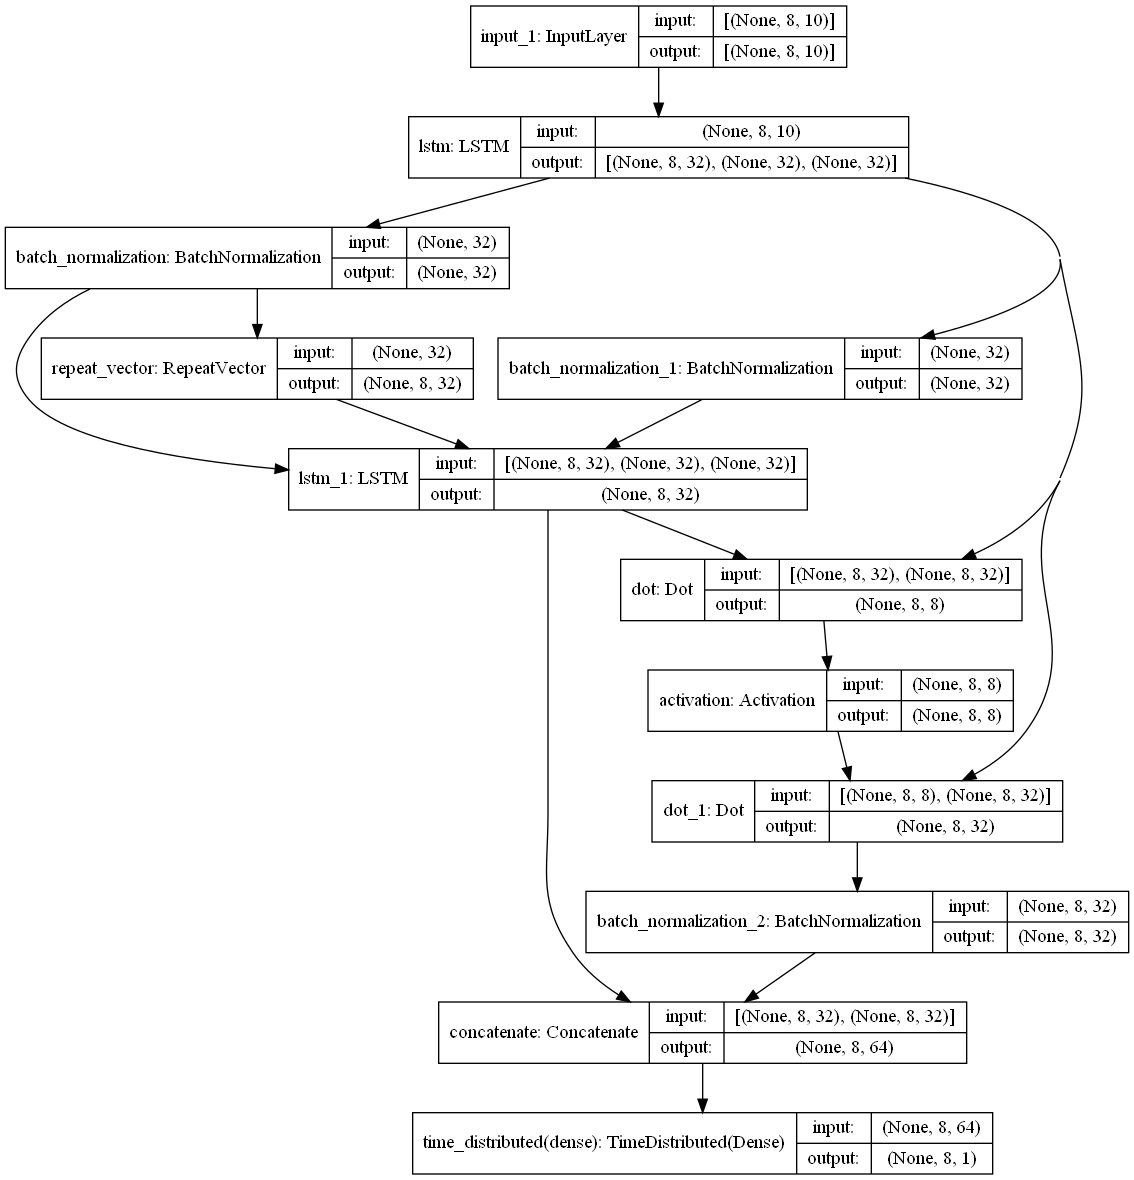

In [25]:
aEncoderInputs = keras.Input(
    shape=(iBackwardTimeWindow, iNrInputFeatures))

aEncoderHiddens, aFinalH, aFinalC = keras.layers.LSTM(iNrOfHiddenNeurons,
                                         return_state = True, 
                                         return_sequences = True
                                        )(aEncoderInputs)
aFinalH = keras.layers.BatchNormalization()(aFinalH)
aFinalC = keras.layers.BatchNormalization()(aFinalC)

aDecoderInputs = keras.layers.RepeatVector(iForwardTimeWindow)(aFinalH)

aDecoderHiddens = keras.layers.LSTM(iNrOfHiddenNeurons, 
                       return_state = False, 
                       return_sequences = True
                      )(aDecoderInputs, initial_state=[aFinalH, aFinalC])

aAttentions = keras.layers.dot([aDecoderHiddens, aEncoderHiddens], axes=[2, 2])
aAttentions = keras.layers.Activation('softmax')(aAttentions)

aContextVector = keras.layers.dot([aAttentions, aEncoderHiddens], axes=[2,1])
aContextVector = keras.layers.BatchNormalization()(aContextVector)
aContextVector = keras.layers.concatenate([aContextVector, aDecoderHiddens])

aDecoderOutputs = keras.layers.TimeDistributed(
    Dense(iNrOutputFeatures)
)(aContextVector)

oPredictiveModel = keras.Model(
    inputs=aEncoderInputs,
    outputs=aDecoderOutputs
)

oOptimizer = tf.keras.optimizers.Adam(learning_rate=1e-05)
oPredictiveModel.compile(optimizer=oOptimizer,
                         loss = "mse"
                        )

tf.keras.utils.plot_model(oPredictiveModel,  show_shapes=True)

### Fit Model

In [26]:
oPredictiveModel.fit(
    aInputTrain, 
    aOutputTrain, 
    epochs=iEpochSize, 
    batch_size=iBatchSize, 
    verbose=1, 
    validation_data= (aInputValidation, aOutputValidation),
    validation_batch_size= iBatchSize,
    callbacks=[oEarlyStop]
)

Epoch 1/10000
15/15 [==============================] - 10s 59ms/step - loss: 0.4112 - val_loss: 0.1474
Epoch 2/10000
15/15 [==============================] - 0s 11ms/step - loss: 0.3939 - val_loss: 0.1445
Epoch 3/10000
15/15 [==============================] - 0s 11ms/step - loss: 0.3754 - val_loss: 0.1413
Epoch 4/10000
15/15 [==============================] - 0s 11ms/step - loss: 0.3582 - val_loss: 0.1381
Epoch 5/10000
15/15 [==============================] - 0s 11ms/step - loss: 0.3455 - val_loss: 0.1345
Epoch 6/10000
15/15 [==============================] - 0s 12ms/step - loss: 0.3289 - val_loss: 0.1307
Epoch 7/10000
15/15 [==============================] - 0s 11ms/step - loss: 0.3147 - val_loss: 0.1268
Epoch 8/10000
15/15 [==============================] - 0s 11ms/step - loss: 0.3026 - val_loss: 0.1231
Epoch 9/10000
15/15 [==============================] - 0s 10ms/step - loss: 0.2832 - val_loss: 0.1190
Epoch 10/10000
15/15 [==============================] - 0s 11ms/step - loss: 0.29

### Save Model

In [27]:
oPredictiveModel.save_weights(sModelName)

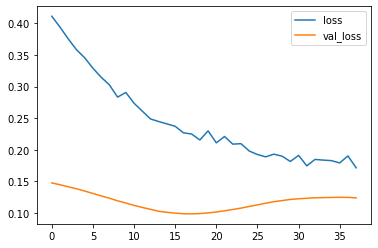

In [28]:
pd.DataFrame(oPredictiveModel.history.history).plot()

## Test

In [29]:
oPredictiveModel.load_weights(sModelName)

aPrediction = oPredictiveModel.predict(aInputTest)
# aPrediction = aConvertFromPixels(aPrediction)
aPrediction = aPrediction.reshape((-1, iForwardTimeWindow * iNrOutputFeatures))
dfPrediction = pd.DataFrame(aPrediction, index = ixTest, columns = ixOutputColums)

aActual = aOutputTest.reshape((-1, iForwardTimeWindow * iNrOutputFeatures))
dfActual =  pd.DataFrame(aActual, index = ixTest, columns = ixOutputColums)

for sOutputFeature in aOutputFeatures:
    sScalerFilePath = os.path.join(sModelName , "__scalers__")
    sScalerFilePath = os.path.join(sScalerFilePath , sOutputFeature + ".sav")
    oScaler = pickle.load(open(sScalerFilePath, 'rb'))
    
    tplMaskFeature = (slice(None), slice(sOutputFeature))
    
    dfPrediction.loc[:,tplMaskFeature] = oScaler.inverse_transform(dfPrediction.loc[:, tplMaskFeature])
    dfActual.loc[:, tplMaskFeature] =  oScaler.inverse_transform(dfActual.loc[:, tplMaskFeature])

# RESULTS

In [30]:
iComparisionTimeStep = 5

In [31]:
y_pred = dfPrediction.iloc[:, iComparisionTimeStep]
y_true = dfActual.iloc[:, iComparisionTimeStep]
aMetrics = [
        ('mean absolute error', mean_absolute_error(y_true, y_pred)),
        ('mean squared error', mean_squared_error(y_true, y_pred)),
        ('max error', max_error(y_true, y_pred)),
        ('r2 score', r2_score(y_true, y_pred))
    ]

print('Metrics for regression:')
for metric_name, metric_value in aMetrics:
    print(f'{metric_name:>25s}: {metric_value: >20.3f}')

Metrics for regression:
      mean absolute error:                0.133
       mean squared error:                0.025
                max error:                0.365
                 r2 score:                0.311


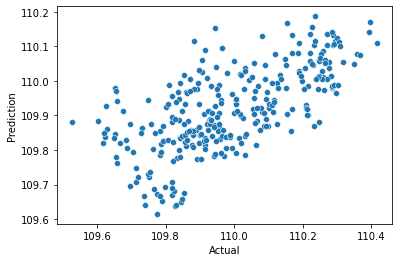

In [32]:
dfTestComparision = pd.DataFrame(dfPrediction.iloc[:,iComparisionTimeStep])
dfTestComparision = dfTestComparision.join(dfActual.iloc[:,iComparisionTimeStep], how = "inner", lsuffix="prediction")
dfTestComparision.columns = ["Prediction", "Actual"]

sns.scatterplot(data = dfTestComparision, x = "Actual", y ="Prediction")

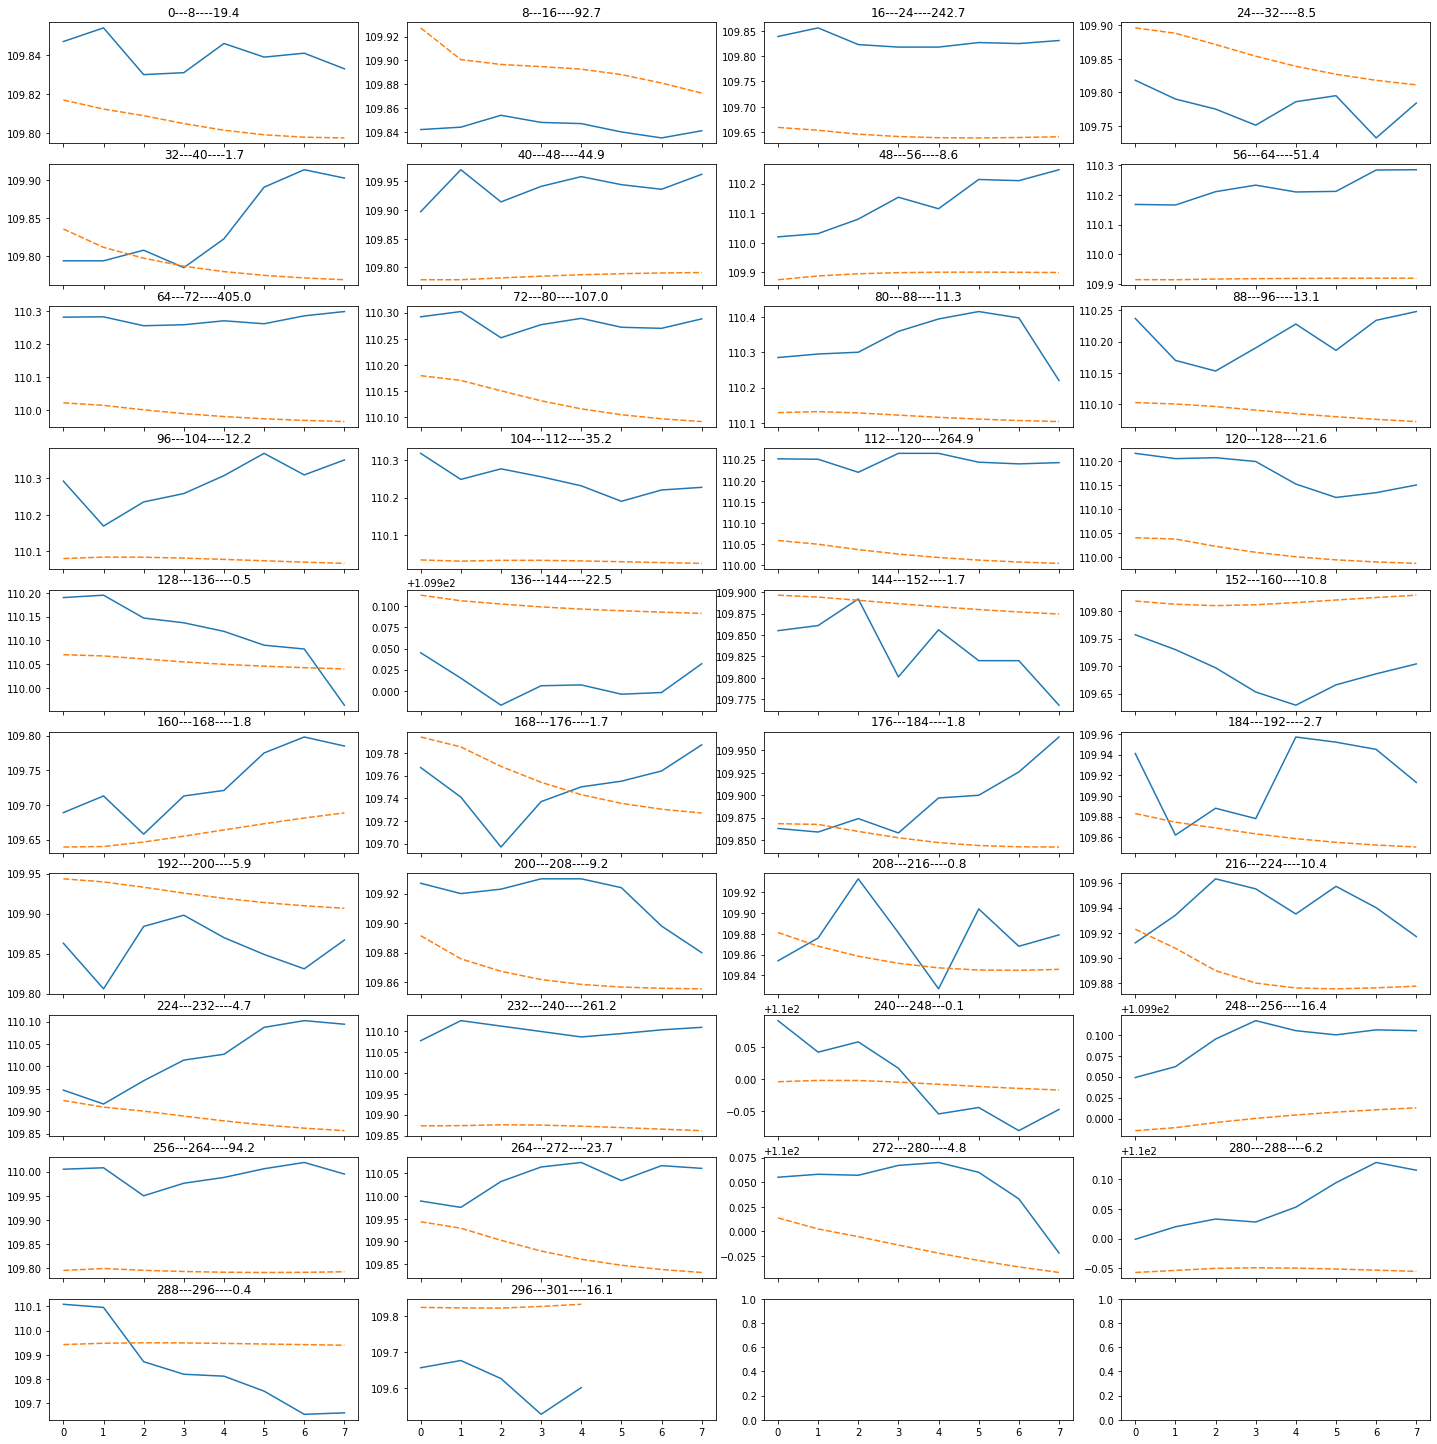

In [33]:
import matplotlib.pyplot as plt

iNrOfCols = 4
iNrOfRows = int(((len(dfActual)/4)/iForwardTimeWindow) + 1)
oFig, aAxises = plt.subplots(iNrOfRows, iNrOfCols, figsize=(20,20), sharex = True)
oFig.tight_layout()
i = 0
for iSampleNr in range(0, len(dfActual), iForwardTimeWindow):
    iFrom = iSampleNr
    iTo = iFrom + iForwardTimeWindow

    if iTo >= len(dfActual):
        iTo = len(dfActual) 
    
    dfStepComparision = dfActual.iloc[iFrom:iTo].loc[:, (slice(None), slice(sOutputFeature))].loc[:, 0]
    dfStepComparision.columns = ["Actual"]

    dfStepComparision["Prediction"] =dfPrediction.iloc[iFrom].iloc[0:iTo-iFrom].loc[:, aOutputFeatures].values
    
    sTitleName = str(iFrom) + "---" + str(iTo) + "---" + str(round(r2_score(dfStepComparision["Actual"], dfStepComparision["Prediction"]),1))
    
    iSampleGraphRow =  int(i/iNrOfCols)
    iSampleGraphCol = int(i%iNrOfCols)
    
    dfStepComparision.reset_index(inplace = True)
    sns.lineplot(ax =aAxises[iSampleGraphRow,iSampleGraphCol] , data = dfStepComparision, legend = False).set_title(sTitleName)
    
    i = i + 1


# REFERENCES

https://www.tensorflow.org/guide/keras/train_and_evaluate#passing_data_to_multi-input_multi-output_models

https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch/

https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit/

https://towardsdatascience.com/customize-loss-function-to-make-lstm-model-more-applicable-in-stock-price-prediction-b1c50e50b16c

https://keras.io/getting_started/faq/

https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/

https://www.tensorflow.org/tutorials/structured_data/time_series

https://towardsdatascience.com/encoder-decoder-model-for-multistep-time-series-forecasting-using-pytorch-5d54c6af6e60

https://levelup.gitconnected.com/building-seq2seq-lstm-with-luong-attention-in-keras-for-time-series-forecasting-1ee00958decb